Potential Energy

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/')

['leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge300day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge60day']

In [3]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr').isel(Time=slice(-50,None))

In [4]:
# To work with APE, instead of PE
ds['e'] = ds.e - ds.e.isel(Time=0).mean(['xh','yh'])

In [5]:
# There is a repeated value in the way MOM6 outputs data, this is being removed here.
ds = ds.isel(xq=slice(1,None), yq=slice(1,None))

In [6]:
import gcm_filters as gcmf
from xgcm import Grid

In [7]:
def div_uh(ds): 
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])
    
    dx = ds.xh.diff('xh')[0].values*1e3
    
    uh = ds.u * xgrid.interp(ds.h, 'X', boundary='periodic')
    vh = ds.v * xgrid.interp(ds.h, 'Y', boundary='extend')

    uh_x = xgrid.diff(uh, 'X', boundary='periodic')/dx
    vh_y = xgrid.diff(vh, 'Y', boundary='extend')/dx

    div_uh = uh_x + vh_y

    return div_uh

In [9]:
def filter_dataset(ds, Lfilter): 
    
    dx = ds.xh.diff('xh')[0].values*1e3
    wet_mask_C= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    wet_mask_x= (ds.u.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    wet_mask_y= (ds.v.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    
    
    filter_C = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR)
                     #grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     #grid_vars = {'wet_mask': wet_mask_C})
    filter_x = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR)
                     #grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     #grid_vars = {'wet_mask': wet_mask_x})

    filter_y = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR)
                     #grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     #grid_vars = {'wet_mask': wet_mask_y})
    
    
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])
    
    ds_filt = xr.Dataset() # For storing the filtered data 

    print('Started')
    ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
    ds_filt['e'] = filter_C.apply(ds.e, dims=['yh','xh']).rename('e')

    ds_filt['filt_mask'] = wet_mask_C.where( (ds.yh > ds.yh.min() + Lfilter/1e3) & (ds.yh < ds.yh.max() - Lfilter/1e3))
    
    # u_c = xgrid.interp(ds.u.fillna(0), 'X')
    # v_c = xgrid.interp(ds.v.fillna(0), 'Y')
    #ds_filt['u'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
    #ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')
    ds_filt['u'] = filter_x.apply(ds.u, dims=['yh','xq']).rename('u')
    ds_filt['v'] = filter_y.apply(ds.v, dims=['yq','xh']).rename('v')

    
    ds_filt['div_uhbar'] = filter_C.apply(ds.div_uh, dims=['yh','xh'])

    ds_filt['div_ubarhbar'] = div_uh(ds_filt)
    ds_filt['div_uphp'] = ds_filt['div_uhbar'] - ds_filt['div_ubarhbar']
    # print('Filtered fields computed')
    
    # ds_filt['uh'] = ds.h*u_c
    # ds_filt['vh'] = ds.h*v_c
    
    # ds_filt['uu'] = u_c*u_c
    # ds_filt['vv'] = v_c*v_c
    
    # ds_filt['uh_bar'] = filter_C.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
    # ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
    
    # ds_filt['uu_bar'] = filter_C.apply(ds_filt['uu'], dims=['yh','xh']).rename('uu_bar')
    # ds_filt['vv_bar'] = filter_C.apply(ds_filt['vv'], dims=['yh','xh']).rename('vv_bar')
    
    # ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
    # ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
    
    # ds_filt['ubar_ubar'] = (ds_filt.u*ds_filt.u)
    # ds_filt['vbar_vbar'] = (ds_filt.v*ds_filt.v)
    
    # ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']
    # ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']
    
    # ds_filt['uu_sg'] = ds_filt['uu_bar'] - ds_filt['ubar_ubar']
    # ds_filt['vv_sg'] = ds_filt['vv_bar'] - ds_filt['vbar_vbar']
    
    # print('Fluxes computed')
    
    # ds_filt['dudx'] = xgrid.interp(xgrid.diff(ds_filt.u, 'X')/dx, 'X')
    # ds_filt['dvdx'] = xgrid.interp(xgrid.diff(ds_filt.v, 'X')/dx, 'X')
    # ds_filt['dudy'] = xgrid.interp(xgrid.diff(ds_filt.u, 'Y')/dx, 'Y')
    # ds_filt['dvdy'] = xgrid.interp(xgrid.diff(ds_filt.v, 'Y')/dx, 'Y')
    # ds_filt['slope_x'] = xgrid.interp(xgrid.diff(ds_filt.e, 'X')/dx, 'X')
    # ds_filt['slope_y'] = xgrid.interp(xgrid.diff(ds_filt.e, 'Y')/dx, 'Y')
    
    # print('Gradients computed')
    
    return ds_filt

In [ ]:
ds['div_uh'] = div_uh(ds)

In [10]:
ds_filt = filter_dataset(ds, 50e3)

Started


/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.11/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [11]:
ds_filt.load();

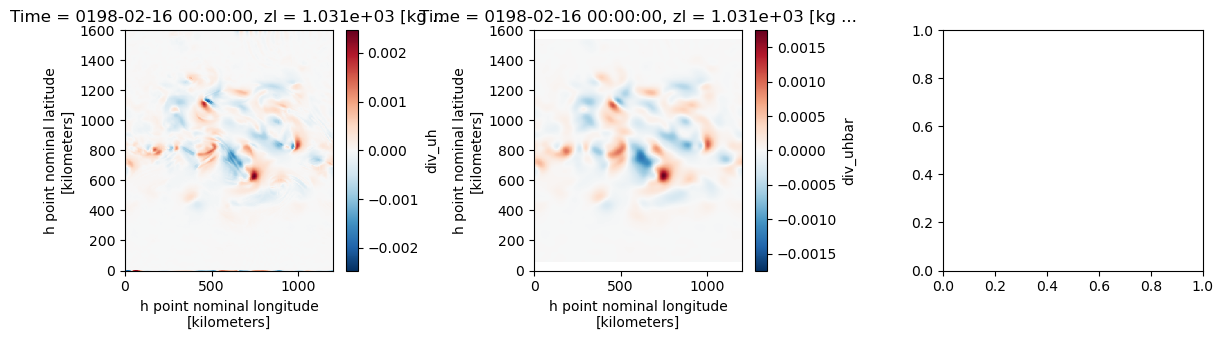

In [12]:
plt.figure(figsize=(12,3.5))

plt.subplot(131)
ds.div_uh.isel(Time=-1, zl=0).plot()

plt.subplot(132)
ds_filt.div_uhbar.isel(Time=-1, zl=0).plot()

plt.subplot(133)
#(ds - ds_filt).div_uh.isel(Time=-1, zl=0).plot()

plt.tight_layout()

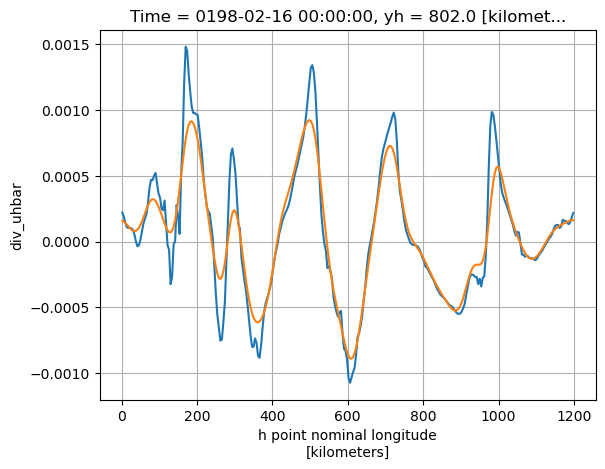

In [13]:
ds.div_uh.isel(Time=-1, zl=0, yh=200).plot()
ds_filt.div_uhbar.isel(Time=-1, zl=0, yh=200).plot()
plt.grid()

In [14]:
def PE(ds): 
    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    PEi = 0.5 * ds.gr * (ds.e**2)

    PE = PEi.sum('zi')

    return PE, PEi

In [15]:
ds['PE'], ds['PEi'] = PE(ds)

In [16]:
ds_filt['MPE'], ds_filt['MPEi'] = PE(ds_filt)

In [17]:
ds_filt['EPE'] = ds['PE'] - ds_filt['MPE']
ds_filt['EPEi'] = ds['PEi'] - ds_filt['MPEi']

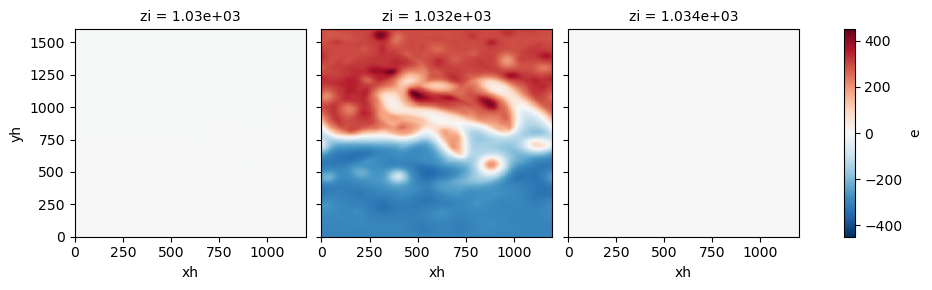

In [18]:
ds.e.isel(Time=-1).plot(col='zi')

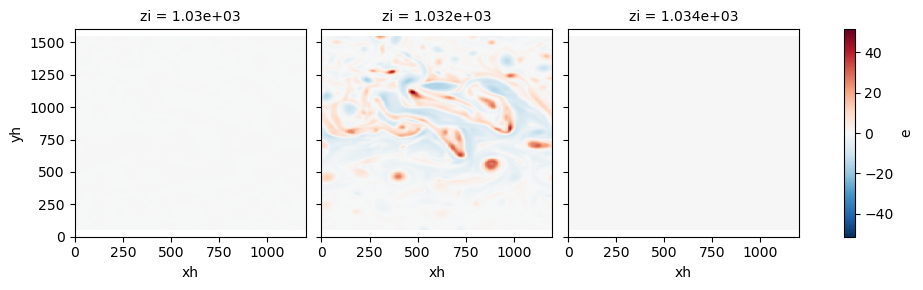

In [19]:
(ds-ds_filt).where(ds_filt.filt_mask>0).e.isel(Time=-1).plot(col='zi')

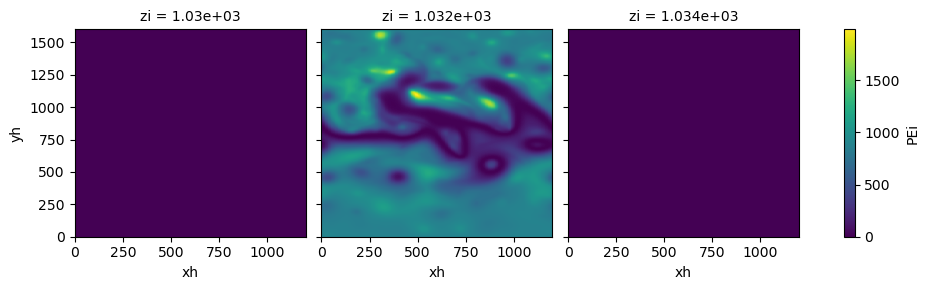

In [20]:
ds.PEi.isel(Time=-1).plot(col='zi')

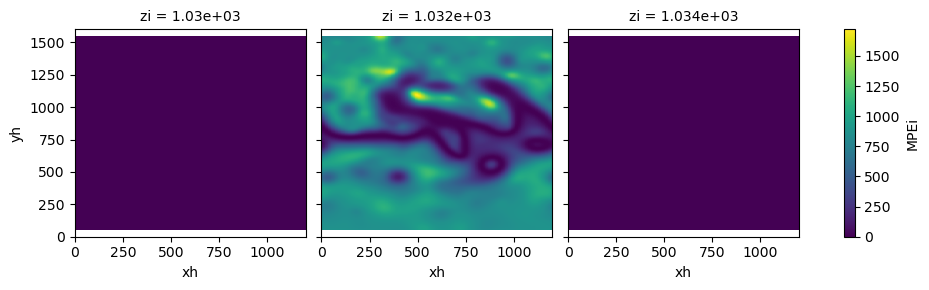

In [21]:
ds_filt.MPEi.where(ds_filt.filt_mask>0).isel(Time=-1).plot(col='zi')

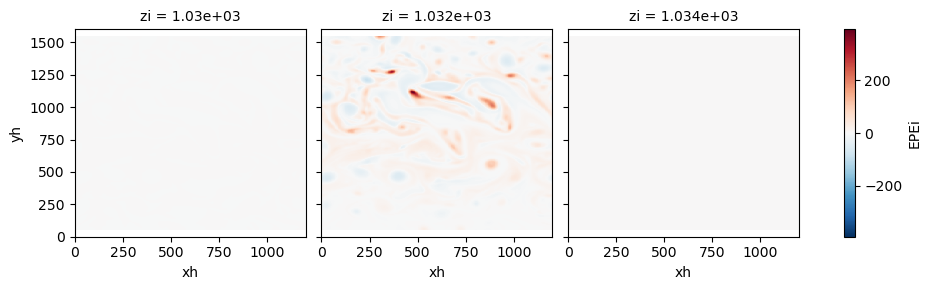

In [22]:
ds_filt.EPEi.where(ds_filt.filt_mask>0).isel(Time=-1).plot(col='zi')

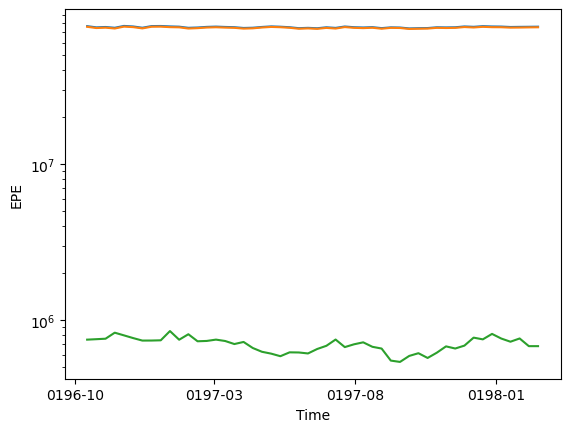

In [23]:
ds.PE.where(ds_filt.filt_mask>0).sum(['xh', 'yh']).plot()
ds_filt.MPE.where(ds_filt.filt_mask>0).sum(['xh', 'yh']).plot()
ds_filt.EPE.where(ds_filt.filt_mask>0).sum(['xh', 'yh']).plot()
plt.yscale('log')

## Spectral 

In [24]:
import xrft

In [25]:
eta = ds.e
da_dft = xrft.dft(eta, dim='xh', true_phase=True, true_amplitude=True)
dx = ds.xh[1] - ds.xh[0]
real_space = (eta**2 * dx).sum('xh')
fourier_space = np.abs(da_dft * da_dft.conj() * da_dft.freq_xh.spacing ).sum('freq_xh')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


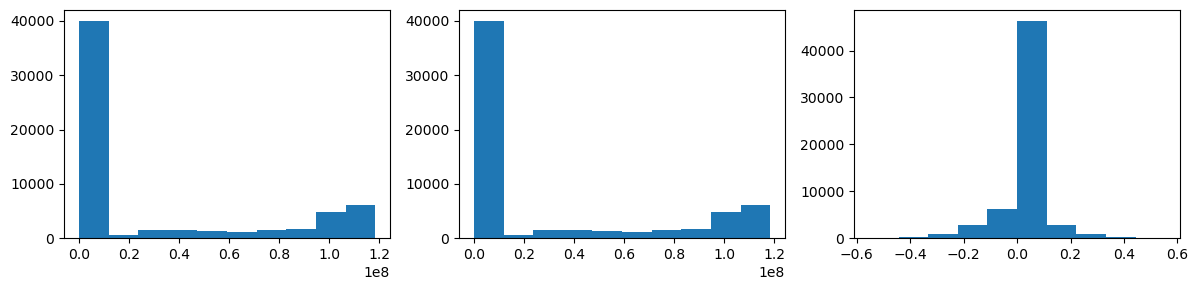

In [26]:
plt.figure(figsize=(12, 3))

plt.subplot(131)
real_space.plot()

plt.subplot(132)
fourier_space.plot()
#PS_e_sum.plot()

plt.subplot(133)

(real_space - fourier_space).plot()

plt.tight_layout()

In [27]:
PS_e = xrft.power_spectrum(ds.e.where(ds_filt.filt_mask>0).isel(zi=1), dim='xh')
PS_efilt = xrft.power_spectrum(ds_filt.e.where(ds_filt.filt_mask>0).isel(zi=1), dim='xh')
PS_epfilt = xrft.power_spectrum( (ds - ds_filt).e.where(ds_filt.filt_mask>0).isel(zi=1), dim='xh')

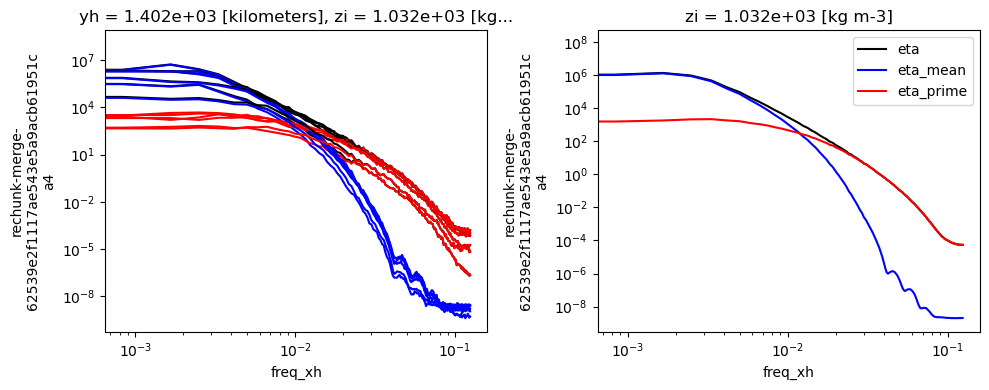

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
for i in [100, 150, 200, 250, 300, 350]:
    PS_e.mean('Time').isel(yh=i).plot(color='k')

    PS_efilt.mean('Time').isel(yh=i).plot(color='b')

    PS_epfilt.mean('Time').isel(yh=i).plot(color='r')
#PS_e.mean('Time').isel(yh=200).plot()
#PS_e.mean('Time').isel(yh=300).plot()

plt.yscale('log')
plt.xscale('log')

plt.subplot(122)
PS_e.mean('Time').mean('yh').plot(color='k', label='eta')
PS_efilt.mean('Time').mean('yh').plot(color='b', label='eta_mean')
PS_epfilt.mean('Time').mean('yh').plot(color='r', label='eta_prime')
plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.tight_layout()

## Tendencies

In [29]:
def eta_tend(ds, var = 'div_uh'): 

    eta_tend = np.zeros_like(ds.e)

    for i in range(len(ds.zl)):
        eta_tend[:,i,:,:] = - ds[var].isel(zl=slice(i,None)).sum('zl')

    eta_tend = xr.DataArray(eta_tend, dims=ds.e.dims)

    return eta_tend

In [30]:
ds['dt_eta'] = eta_tend(ds)

In [31]:
ds_filt['dt_eta'] = eta_tend(ds_filt, var='div_uhbar')
ds_filt['dt_eta_mean_by_mean'] = eta_tend(ds_filt, var='div_ubarhbar')
ds_filt['dt_eta_mean_by_eddy'] = eta_tend(ds_filt, var='div_uphp')

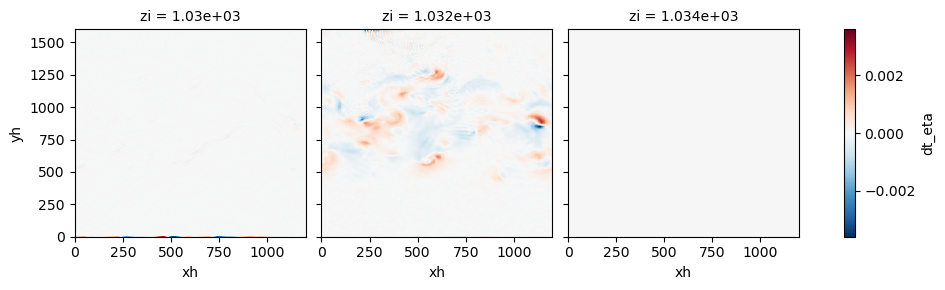

In [32]:
ds.dt_eta.isel(Time=0).plot(col='zi')

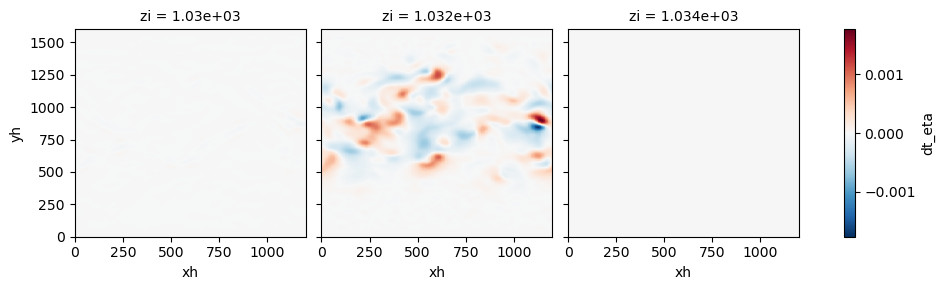

In [33]:
ds_filt.dt_eta.isel(Time=0).plot(col='zi')

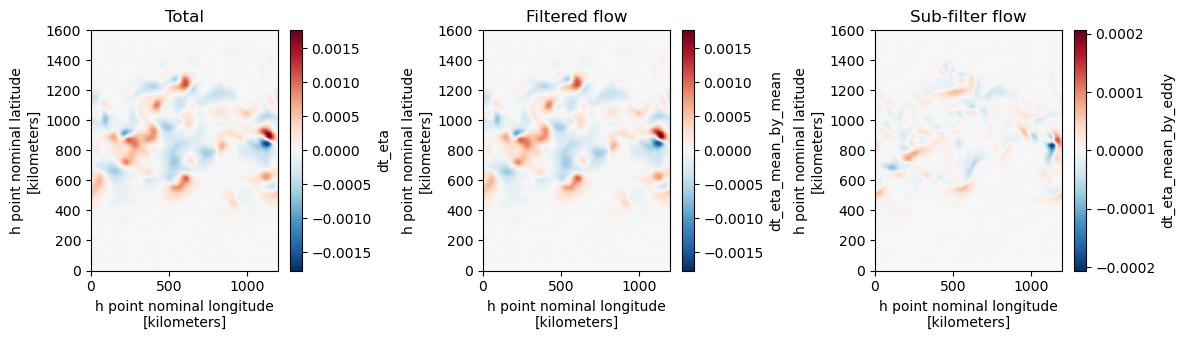

In [34]:
plt.figure(figsize=(12, 3.5))

plt.subplot(131)
ds_filt.dt_eta.isel(Time=0, zi=1).plot()
plt.title('Total')

plt.subplot(132)
ds_filt.dt_eta_mean_by_mean.isel(Time=0, zi=1).plot()
plt.title('Filtered flow')

plt.subplot(133)
ds_filt.dt_eta_mean_by_eddy.isel(Time=0, zi=1).plot()
plt.title('Sub-filter flow')

plt.tight_layout()

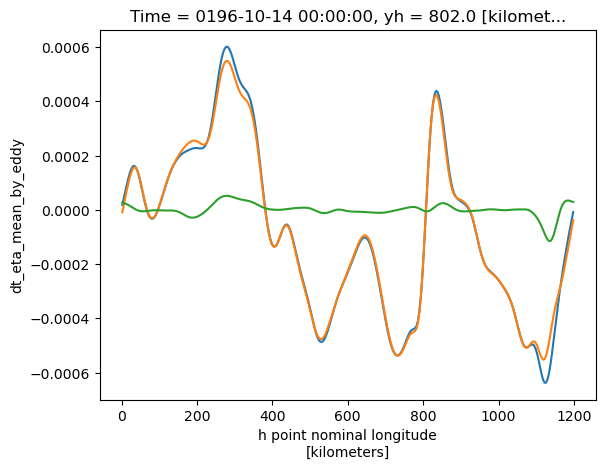

In [35]:
ds_filt.dt_eta.isel(Time=0, zi=1, yh=200).plot()
ds_filt.dt_eta_mean_by_mean.isel(Time=0, zi=1, yh=200).plot()
ds_filt.dt_eta_mean_by_eddy.isel(Time=0, zi=1, yh=200).plot()

In [36]:
def PE_tend(ds, var = 'dt_eta'): 
    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    PE_tend_i = (ds.gr * ds.e * ds[var])
    PE_tend = (ds.gr * ds.e * ds[var]).sum('zi')
    

    return PE_tend, PE_tend_i

In [37]:
ds['PE_tend'],_ = PE_tend(ds)

In [38]:
ds_filt['MPE_tend_mean'], ds_filt['MPEi_tend_mean'] = PE_tend(ds_filt, var='dt_eta_mean_by_mean')
ds_filt['MPE_tend_eddy'], ds_filt['MPEi_tend_eddy'] = PE_tend(ds_filt, var='dt_eta_mean_by_eddy')

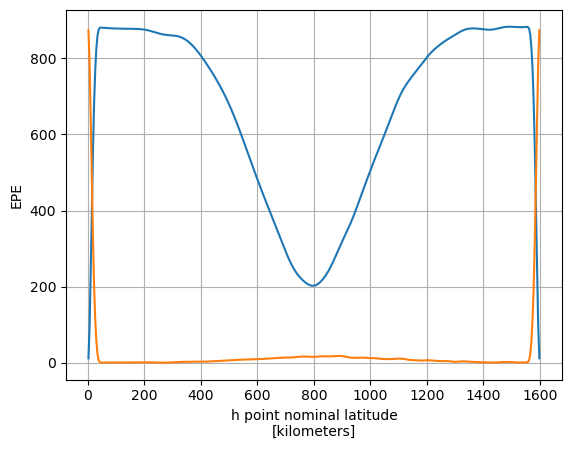

In [39]:
ds_filt.MPE.mean(['xh','Time']).plot()
ds_filt.EPE.mean(['xh','Time']).plot()
plt.grid()

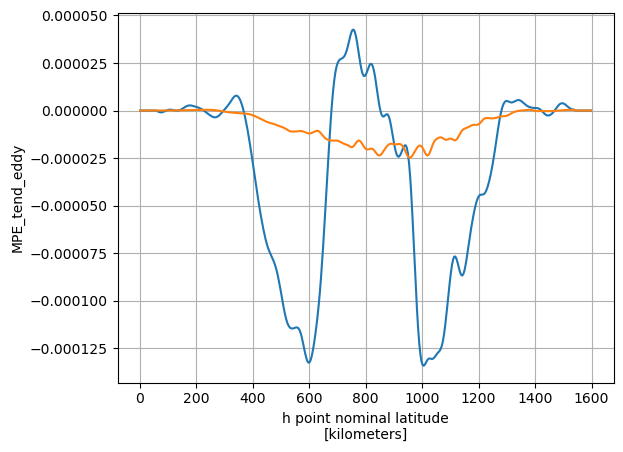

In [40]:
ds_filt.MPE_tend_mean.mean(['xh','Time']).plot()
ds_filt.MPE_tend_eddy.mean(['xh','Time']).plot()
plt.grid()

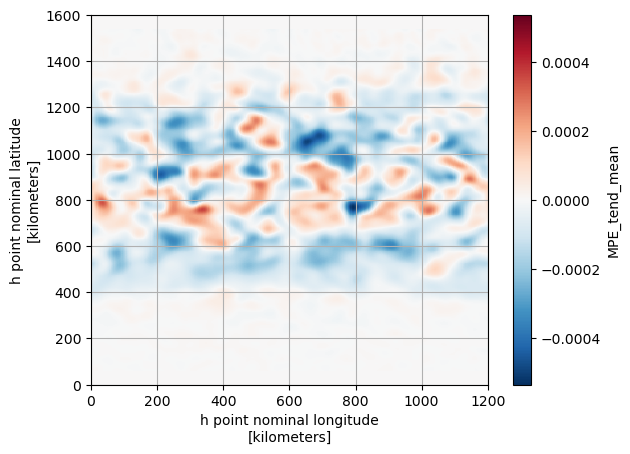

In [41]:
ds_filt.MPE_tend_mean.mean(['Time']).plot()
plt.grid()

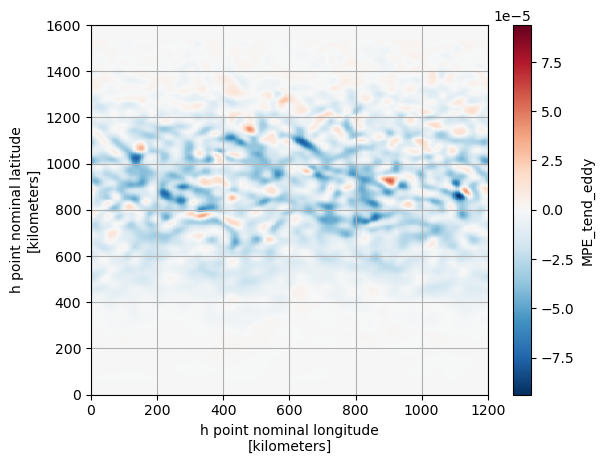

In [42]:
ds_filt.MPE_tend_eddy.mean(['Time']).plot()
plt.grid()

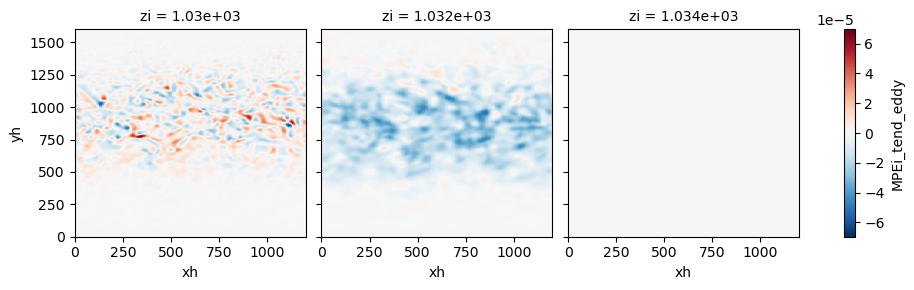

In [43]:
ds_filt.MPEi_tend_eddy.mean('Time').plot(col='zi')

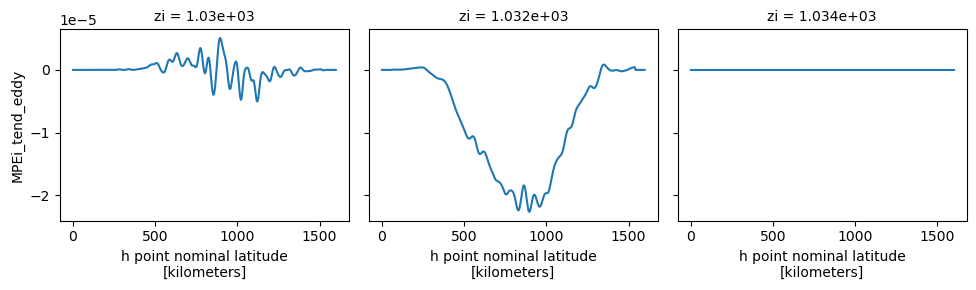

In [44]:
ds_filt.MPEi_tend_eddy.mean(['Time','xh']).plot(col='zi')

In [45]:
def PE_tend_spectral(ds, var = 'dt_eta'): 
    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    #e_dft = xrft.dft(ds.e, dim='xh', true_phase=True, true_amplitude=True)
    #var_dft = xrft.dft(ds[var], dim='xh', true_phase=True, true_amplitude=True)

    e_dft = xrft.dft(ds.e, dim='xh')
    var_dft = xrft.dft(ds[var], dim='xh')
    
    PE_tend_i = (ds.gr * e_dft * np.conjugate(var_dft)).real
    PE_tend = PE_tend_i.sum('zi')
    
    return PE_tend, PE_tend_i

In [46]:
temp,_ = PE_tend_spectral(ds_filt, var='dt_eta_mean_by_eddy')

/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.11/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


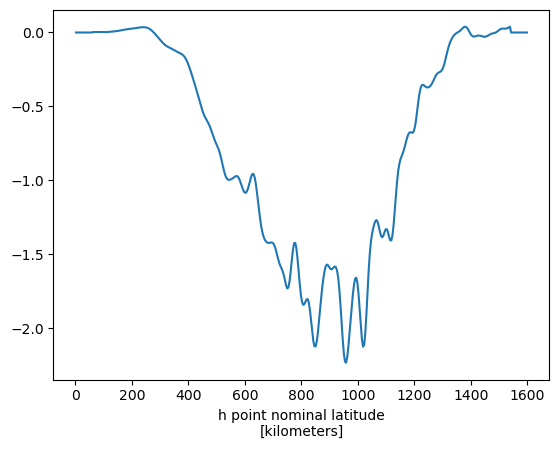

In [47]:
temp.sum('freq_xh').mean(['Time']).plot()

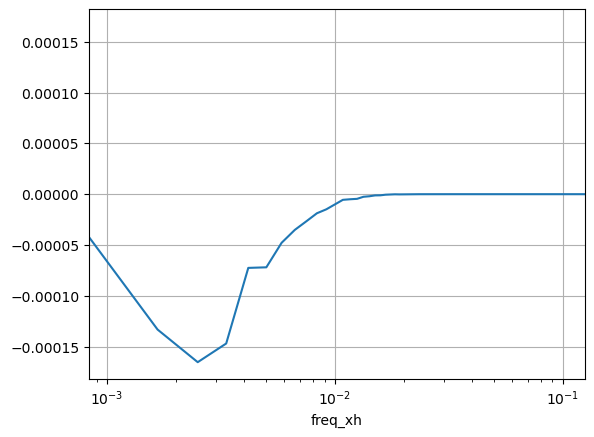

In [48]:
(temp.freq_xh * temp.sel(yh=slice(250, 1250))).mean(['Time','yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()

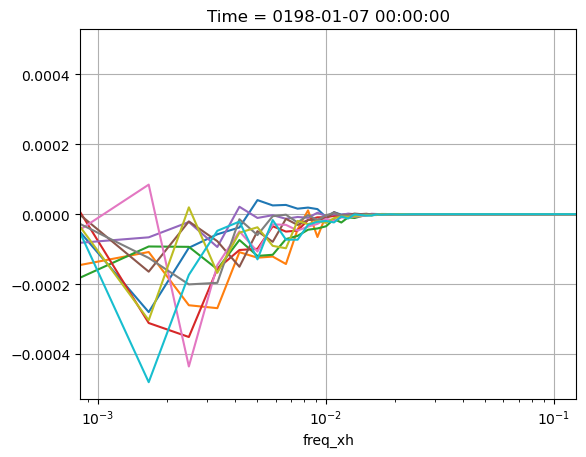

In [49]:
for i in range(0, 50, 5):
    (temp.freq_xh * temp.sel(yh=slice(250, 1250))).isel(Time=i).mean(['yh']).plot()
plt.xlim([1/1200, 1/8])
#plt.ylim([-5,0.2])
plt.xscale('log')
plt.grid()